# ScriptVista - Handwriting Recognition

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

train = pd.read_csv('./datasets/Handwriting Recognition/written_name_train_v2.csv')
test = pd.read_csv('./datasets/Handwriting Recognition/written_name_validation_v2.csv')
train_img_dir = './datasets/Handwriting Recognition/train_v2/train'
test_img_dir = './datasets/Handwriting Recognition/validation_v2/validation'

train = train[train['IDENTITY'] != 'UNREADABLE'].dropna()
test = test[test['IDENTITY'] != 'UNREADABLE'].dropna()

## Image Preprocessing

In [2]:
def to_binary(image):
    image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), dsize=(284, 62))
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image_binary = image_binary / 255
    return image_binary

def load_and_preprocess_data(data, img_dir, num_samples=1000):
    data_img = []
    data_idt = []
    for i in range(min(num_samples, data.shape[0])):
        image_filename = data['FILENAME'].iloc[i]
        image_path = os.path.join(img_dir, image_filename)
        image = cv2.imread(image_path)
        image = to_binary(image)
        data_img.append(image)
        data_idt.append(data['IDENTITY'].iloc[i])
    return np.array(data_img), data_idt

train_data_img, train_data_idt = load_and_preprocess_data(train, train_img_dir)
test_data_img, test_data_idt = load_and_preprocess_data(test, test_img_dir)

## Label Binarization & Data Conversion

In [3]:
all_data = train_data_idt + test_data_idt
unique_characters_list = sorted(set(''.join(all_data)))
num_classes = len(unique_characters_list)

lb = {char: i for i, char in enumerate(unique_characters_list)}

def name_to_vectors(name, max_len):
    vectors = [lb[char] for char in name]
    vectors += [0] * (max_len - len(name))
    return vectors

length_of_longest_word = max(len(max(train_data_idt, key=len)), len(max(test_data_idt, key=len)))

vectors_list_train_idt = [name_to_vectors(name, length_of_longest_word) for name in train_data_idt]
vectors_list_test_idt = [name_to_vectors(name, length_of_longest_word) for name in test_data_idt]

vectors_list_train_idt = np.array(vectors_list_train_idt)
vectors_list_test_idt = np.array(vectors_list_test_idt)

## Conevert Data To PyTorch Tensors

In [4]:
train_data_img = torch.tensor(train_data_img, dtype=torch.float32)
vectors_list_train_idt = torch.tensor(vectors_list_train_idt, dtype=torch.long)

test_data_img = torch.tensor(test_data_img, dtype=torch.float32)
vectors_list_test_idt = torch.tensor(vectors_list_test_idt, dtype=torch.long)

batch_size = 8
train_dataset = torch.utils.data.TensorDataset(train_data_img, vectors_list_train_idt)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

## Model Training

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 35, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        print(x.size())  # Print the size of the tensor
        x = x.view(-1, 16 * 7 * 35)  # Adjust the size here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_data_img, vectors_list_train_idt = train_data_img.to(device), vectors_list_train_idt.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.unsqueeze(1))  # Add channel dimension
        loss = criterion(outputs, labels.argmax(dim=1))
        loss.backward()
        optimizer.step()

torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
torch.Size([8, 16, 7, 35])
t

## Model Testing & Evaluation

In [6]:
test_outputs = model(test_data_img.unsqueeze(1))
_, predicted = torch.max(test_outputs, 1)

# Print accuracy
accuracy = (predicted == vectors_list_test_idt.argmax(dim=1)).sum().item() / len(test_data_idt)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

torch.Size([1000, 16, 7, 35])
Test Accuracy: 21.80%


## Display Images From The Dataset

BALTHAZAR
(62, 284)


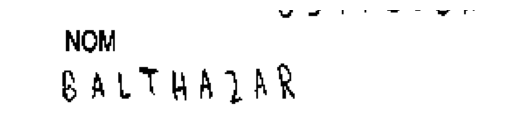

SIMON
(62, 284)


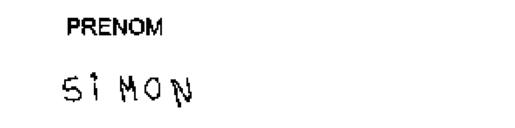

BENES
(62, 284)


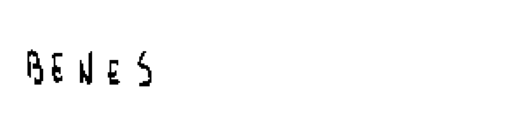

LA LOVE
(62, 284)


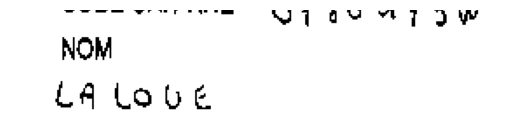

DAPHNE
(62, 284)


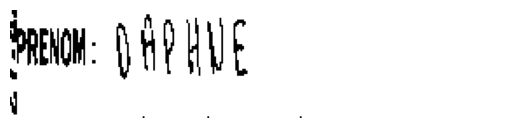

BILEL
(62, 284)


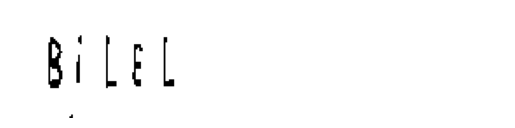

LAUMIONIER
(62, 284)


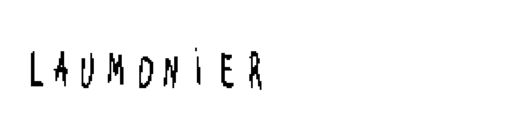

LEA
(62, 284)


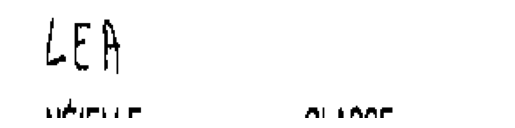

JEAN-ROCH
(62, 284)


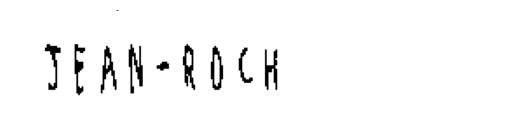

RUPP
(62, 284)


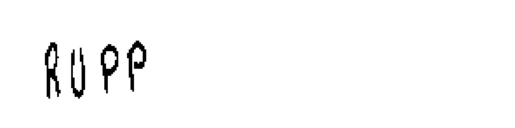

In [7]:
# Display images from the training set
for i in range(5):
    print(train_data_idt[i])
    img = train_data_img[i].numpy().squeeze()  # Convert tensor to NumPy array and remove singleton dimension
    print(img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Display images from the test set
for i in range(5):
    print(test_data_idt[i])
    img = test_data_img[i].numpy().squeeze()  # Convert tensor to NumPy array and remove singleton dimension
    print(img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

## Self Image Prediction

In [8]:
self_image_path = './datasets/self/a.jpg'
self_image = cv2.imread(self_image_path)
self_image_binary = to_binary(self_image)

self_image_tensor = torch.tensor(self_image_binary, dtype=torch.float32).unsqueeze(0)

self_image_tensor = self_image_tensor.to(device)
model.eval()
with torch.no_grad():
    output = model(self_image_tensor.unsqueeze(1))

_, predicted_labels = torch.max(output, 1)
predicted_characters = [char for char, label in lb.items() if label == predicted_labels.item()][0]
print(f'Predicted: {predicted_characters}')

torch.Size([1, 16, 7, 35])
Predicted: A
